In [1]:
import os
import torch
import torchaudio
import matplotlib.pyplot as plt
import time
import wandb

from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import soundfile as sf
import torchaudio.transforms as T

from sklearn.metrics import f1_score

In [ ]:
wandb.login(key="put you wandb api key here")

class WandbExperimentManager:
    def __init__(self):
        self.entity = "maksymiuk-radoslaw-politechnika-warszawska"
        self.project = "wztum-2025L-project"
    
    def start_run(self, name, config):
        return wandb.init(
            entity=self.entity,
            project=self.project,
            name=name,
            config=config,
            reinit=True  
        )
    
    def finish(self):
        wandb.finish()

wandb_experiment_manager = WandbExperimentManager()

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\maksy\_netrc
wandb: Currently logged in as: maksymiuk-radoslaw (maksymiuk-radoslaw-politechnika-warszawska) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


# Wczytywanie plików audio

In [3]:
class AudioDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        If root_dir contains subfolders, each is treated as a label.
        Otherwise, root_dir is assumed to be a single class.
        Labels are remapped so that only allowed test classes are kept;
        all other labels are mapped to "unknown".
        """
        self.root_dir = root_dir
        self.transform = transform
        self.filepaths = []
        self.labels = []
        self.label2idx = {}
        self.idx2label = {}

        # Allowed test classes from train (silence is not expected in train)
        allowed = {"yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"}
        
        subdirs = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
        
        if subdirs:
            # Find allowed labels that appear in the training folders.
            allowed_in_train = sorted([d for d in subdirs if d in allowed])
            # If any subfolder is not in allowed, we will assign it the label "unknown"
            has_unknown = any(d not in allowed for d in subdirs)
            
            # Create label-to-index mapping:
            current_idx = 0
            for label in allowed_in_train:
                self.label2idx[label] = current_idx
                self.idx2label[current_idx] = label
                current_idx += 1
            if has_unknown:
                self.label2idx["unknown"] = current_idx
                self.idx2label[current_idx] = "unknown"
            
            # Read files and map labels accordingly.
            for label in subdirs:
                label_path = os.path.join(root_dir, label)
                for f in os.listdir(label_path):
                    if f.endswith(".wav"):
                        filepath = os.path.join(label_path, f)
                        # If label is allowed, keep it; otherwise, use "unknown"
                        mapped_label = label if label in allowed else "unknown"
                        self.filepaths.append(filepath)
                        self.labels.append(self.label2idx[mapped_label])
        else:
            # No subdirectories – root_dir is treated as one class.
            label = os.path.basename(root_dir)
            mapped_label = label if label in allowed else "unknown"
            self.label2idx[mapped_label] = 0
            self.idx2label[0] = mapped_label
            for f in os.listdir(root_dir):
                if f.endswith(".wav"):
                    self.filepaths.append(os.path.join(root_dir, f))
                    self.labels.append(0)

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        filepath = self.filepaths[idx]
        label = self.labels[idx]
    
        # Load audio using soundfile
        data, sample_rate = sf.read(filepath)
        waveform = torch.tensor(data, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
     
        if self.transform:
            waveform = self.transform(waveform)
    
        return waveform, label

# Transformation: MelSpectrogram + AmplitudeToDB
mel_transform = T.MelSpectrogram(sample_rate=16000, n_mels=64)
db_transform = T.AmplitudeToDB()

def to_mel_spectrogram(waveform):
    waveform = waveform.float() 
    spec = mel_transform(waveform)
    spec_db = db_transform(spec)
    return spec_db  # shape: [1, n_mels, time]

# Function collate, which pads spectrograms of different time lengths
def pad_collate_fn(batch):
    """
    batch: list of tuples (spectrogram, label)
    We assume each spectrogram has shape [1, n_mels, time]
    """
    spectrograms, labels = zip(*batch)
    
    max_time = max(s.size(2) for s in spectrograms)
    
    padded_spectrograms = []
    for s in spectrograms:
        pad_amount = max_time - s.size(2)
        s_padded = F.pad(s, (0, pad_amount), mode='constant', value=0)
        padded_spectrograms.append(s_padded)
    
    batch_spectrograms = torch.stack(padded_spectrograms)
    batch_labels = torch.tensor(labels)
    return batch_spectrograms, batch_labels

# EDA

Liczba przykładów w dataset: 64727
Kształt waveforma: torch.Size([1, 16000])
Etykieta (indeks): 10
Etykieta (nazwisko): unknown


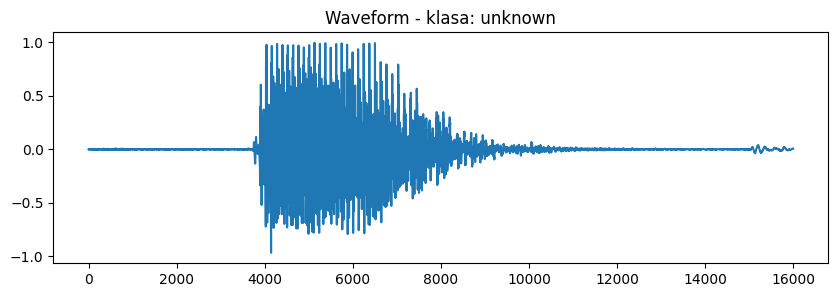

In [4]:
# Test usage of AudioDataset
dataset = AudioDataset(root_dir=os.path.join("..", "data", "train", "audio"), transform=None)

print("Liczba przykładów w dataset:", len(dataset))

waveform, label = dataset[2000]
print("Kształt waveforma:", waveform.shape)  # [1, no. of samples]
print("Etykieta (indeks):", label)
print("Etykieta (nazwisko):", dataset.idx2label[label])

plt.figure(figsize=(10, 3))
plt.title(f"Waveform - klasa: {dataset.idx2label[label]}")
plt.plot(waveform.t().numpy())
plt.show()


# Spektogram

In [5]:
mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=16000, 
    n_mels=64
)
db_transform = torchaudio.transforms.AmplitudeToDB()

def to_mel_spectrogram(waveform):
    spec = mel_transform(waveform)
    spec_db = db_transform(spec)
    return spec_db


Kształt spektrogramu (Mel, dB): torch.Size([1, 64, 81])


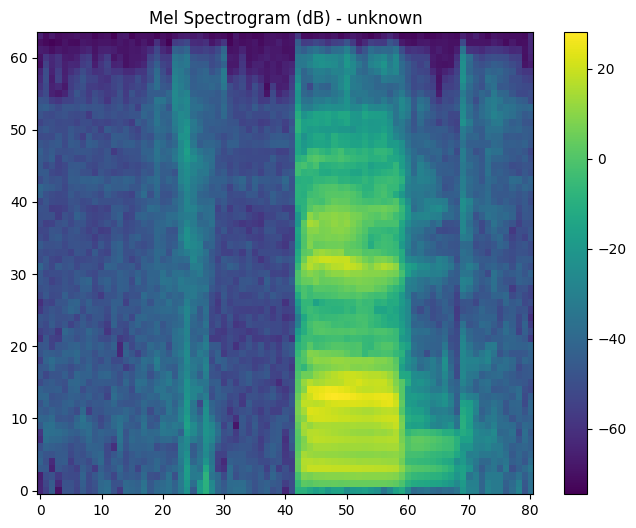

In [6]:
waveform, label = dataset[0]
waveform = waveform.float()  # conversion to float32
spec_db = to_mel_spectrogram(waveform)

print("Kształt spektrogramu (Mel, dB):", spec_db.shape)  # [1, n_mels, time]

plt.figure(figsize=(8, 6))
plt.title(f"Mel Spectrogram (dB) - {dataset.idx2label[label]}")
plt.imshow(spec_db.squeeze().numpy(), origin="lower", aspect="auto", cmap="viridis")
plt.colorbar()
plt.show()


# Zaladowanie danych treningowych

In [7]:
dataset_spec = AudioDataset(root_dir=os.path.join("..", "data", "train", "audio"), transform=to_mel_spectrogram)

# Checking of shape
x, y = dataset_spec[0]
print("Kształt X (spektrogramu):", x.shape)  # [1, n_mels, time]
print("Etykieta:", y, dataset_spec.idx2label[y])


Kształt X (spektrogramu): torch.Size([1, 64, 81])
Etykieta: 10 unknown


## Podział na zbiór treningowy i walidacyjny

In [8]:
train_size = int(0.8 * len(dataset_spec))
val_size = len(dataset_spec) - train_size

train_dataset, val_dataset = random_split(dataset_spec, [train_size, val_size])

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=pad_collate_fn)

print("Liczba próbek w train_loader:", len(train_dataset))
print("Liczba próbek w val_loader:", len(val_dataset))


Liczba próbek w train_loader: 51781
Liczba próbek w val_loader: 12946


## Accuracy dla przypisania najliczniej reprezentowanej klasy

In [9]:
all_labels = [dataset_spec[i][1] for i in range(len(dataset_spec))]
most_common_label = max(set(all_labels), key=all_labels.count)
baseline_acc = all_labels.count(most_common_label) / len(all_labels) * 100

print(f"Najczęstsza klasa: {dataset_spec.idx2label[most_common_label]}")
print(f"Baseline accuracy (majority class): {baseline_acc:.2f}%")


Najczęstsza klasa: unknown
Baseline accuracy (majority class): 63.41%


# CNN

In [10]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        # Input: [batch, 1, n_mels, time]

        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.AdaptiveMaxPool2d((8, 8))  # -> [batch, 16, 8, 8]

        self.fc1 = nn.Linear(16 * 8 * 8, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        # x: [batch, 1, n_mels, time]
        x = F.relu(self.conv1(x))    # -> [batch, 8, n_mels, time]
        x = F.relu(self.conv2(x))    # -> [batch, 16, n_mels, time]
        x = self.pool(x)            # -> [batch, 16, 8, 8]
        x = x.view(x.size(0), -1)   # flattening to [batch, 16*8*8]
        x = F.relu(self.fc1(x))     # -> [batch, 64]
        x = self.fc2(x)             # -> [batch, num_classes]
        return x


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Urządzenie:", device)

Urządzenie: cpu


## Trening CNN

In [ ]:
num_classes = len(dataset_spec.label2idx)
model = SimpleCNN(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 2  

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for i, (inputs, labels) in enumerate(train_loader):
        # inputs: [batch_size, 1, n_mels, time]
        # labels: [batch_size]
        inputs = inputs.to(device)
        labels = labels.to(device)

        
        optimizer.zero_grad()

        # Forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward + opt
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Average loss per epoch
    epoch_loss = running_loss / len(train_loader)
    print(f"[Epoch {epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f}")


[Epoch 1/2] Loss: 0.8881


# Walidacja

In [ ]:
# Validation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs_val, labels_val in val_loader:
        inputs_val = inputs_val.to(device)
        labels_val = labels_val.to(device)

        outputs_val = model(inputs_val)
        _, predicted = torch.max(outputs_val, 1)
        total += labels_val.size(0)
        correct += (predicted == labels_val).sum().item()

val_acc = 100.0 * correct / total
print(f"Val Accuracy: {val_acc:.2f}%\n")

Val Accuracy: 84.00%



# Testy

0. Validation setup

In [ ]:
def train_and_evaluate(model, train_loader, val_loader, optimizer, scheduler=None, num_epochs=2,
                       experiment_name=None, config=None):
    model.to(device)
    criterion = nn.CrossEntropyLoss()

    if experiment_name and config:
        runWANDB = wandb_experiment_manager.start_run(experiment_name, config)

    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)

        # Validation phase
        model.eval()
        correct = 0
        total = 0
        val_loss = 0.0

        # For F1 score
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs_val, labels_val in val_loader:
                inputs_val = inputs_val.to(device)
                labels_val = labels_val.to(device)

                outputs_val = model(inputs_val)
                loss_val = criterion(outputs_val, labels_val)
                val_loss += loss_val.item()

                _, predicted = torch.max(outputs_val, 1)
                total += labels_val.size(0)
                correct += (predicted == labels_val).sum().item()

                all_preds.append(predicted.cpu())
                all_labels.append(labels_val.cpu())

        all_preds = torch.cat(all_preds).numpy()
        all_labels = torch.cat(all_labels).numpy()
        f1_micro = 100.0 * f1_score(all_labels, all_preds, average='micro')
        f1_macro = 100.0 * f1_score(all_labels, all_preds, average='macro')

        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100.0 * correct / total

        # Learning rate scheduling
        if scheduler:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(avg_val_loss)
            else:
                scheduler.step()

        if experiment_name and config:
            wandb.log({
                "epoch": epoch + 1,
                "train_loss": avg_train_loss,
                "val_loss": avg_val_loss,
                "val_accuracy": val_acc,
                "f1_micro": f1_micro,
                "f1_macro": f1_macro,
                "learning_rate": optimizer.param_groups[0]['lr']
            })

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")
        print(f"F1 Micro: {f1_micro:.2f}% | F1 Macro: {f1_macro:.2f}%")

    training_time = time.time() - start_time
    print(f"Total training time: {training_time:.2f} seconds")

    if experiment_name and config:
        wandb_experiment_manager.finish()

    return val_acc

1. Learning Rate

In [ ]:
learning_rates = [0.01, 0.001, 0.0001]
    
for lr in learning_rates:
    model = SimpleCNN(num_classes)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    config = {
        "model_type": "SimpleCNN",
        "optimizer": "Adam",
        "learning_rate": lr,
        "epochs": 2,
    }
    
    acc = train_and_evaluate(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        num_epochs=2,
        experiment_name=f"LR_Experiment_{lr}",
        config=config
    )
    
    print(f"LR={lr} Accuracy: {acc:.2f}%")

Epoch 1/2 | Train Loss: 1.3088 | Val Loss: 1.1691 | Val Acc: 65.16%
F1 Micro: 65.16% | F1 Macro: 19.78%
Epoch 2/2 | Train Loss: 1.1518 | Val Loss: 1.0848 | Val Acc: 66.67%
F1 Micro: 66.67% | F1 Macro: 26.70%
Total training time: 62.05 seconds
Epoch 1/2 | Train Loss: 0.9409 | Val Loss: 0.6507 | Val Acc: 78.03%
F1 Micro: 78.03% | F1 Macro: 60.20%
Epoch 2/2 | Train Loss: 0.5633 | Val Loss: 0.5331 | Val Acc: 82.21%
F1 Micro: 82.21% | F1 Macro: 69.07%
Total training time: 62.10 seconds
Epoch 1/2 | Train Loss: 1.1802 | Val Loss: 0.9495 | Val Acc: 70.34%
F1 Micro: 70.34% | F1 Macro: 39.55%
Epoch 2/2 | Train Loss: 0.8289 | Val Loss: 0.7221 | Val Acc: 76.26%
F1 Micro: 76.26% | F1 Macro: 55.05%
Total training time: 67.00 seconds
LR=0.01 Accuracy: 66.67%
LR=0.001 Accuracy: 82.21%
LR=0.0001 Accuracy: 76.26%


2. Number of Layers and Neurons

In [ ]:
class DeeperCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, 1, 1)
        self.conv2 = nn.Conv2d(8, 16, 3, 1, 1)
        self.conv3 = nn.Conv2d(16, 32, 3, 1, 1)
        self.pool = nn.AdaptiveAvgPool2d((4, 4))
        self.fc = nn.Linear(32 * 4 * 4, num_classes)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

model_shallow = SimpleCNN(num_classes)
model_deep = DeeperCNN(num_classes)

lr = 0.001

config_shallow = {
    "model_type": "SimpleCNN",
    "optimizer": "Adam",
    "learning_rate": lr,
}
config_deep = {
    "model_type": "DeeperCNN",
    "optimizer": "Adam",
    "learning_rate": lr,
}

acc_shallow = train_and_evaluate(
    model_shallow, 
    train_loader, 
    val_loader, 
    optim.Adam(model_shallow.parameters(), lr=lr),
    experiment_name="Shallow_CNN_Experiment",
    config=config_shallow,
)
acc_deep = train_and_evaluate(
    model_deep, 
    train_loader, 
    val_loader, 
    optim.Adam(model_deep.parameters(), lr=0.001),
    experiment_name="Deeper_CNN_Experiment",
    config=config_deep,
)

print(f"Shallow CNN Accuracy: {acc_shallow:.2f}%")
print(f"Deeper CNN Accuracy: {acc_deep:.2f}%")

Epoch 1/2 | Train Loss: 0.9639 | Val Loss: 0.6959 | Val Acc: 76.84%
F1 Micro: 76.84% | F1 Macro: 57.82%
Epoch 2/2 | Train Loss: 0.6251 | Val Loss: 0.5883 | Val Acc: 80.54%
F1 Micro: 80.54% | F1 Macro: 66.38%
Total training time: 64.23 seconds
Epoch 1/2 | Train Loss: 0.9574 | Val Loss: 0.6191 | Val Acc: 79.99%
F1 Micro: 79.99% | F1 Macro: 65.45%
Epoch 2/2 | Train Loss: 0.5544 | Val Loss: 0.5224 | Val Acc: 82.44%
F1 Micro: 82.44% | F1 Macro: 69.25%
Total training time: 68.51 seconds
Shallow CNN Accuracy: 80.54%
Deeper CNN Accuracy: 82.44%


3. Conv Layer Params (Stride and Filter Size)

In [ ]:
model_stride1 = SimpleCNN(num_classes)
model_stride2 = SimpleCNN(num_classes)

model_stride1.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
model_stride2.conv1 = nn.Conv2d(1, 8, kernel_size=5, stride=2, padding=2)

acc_stride1 = train_and_evaluate(model_stride1, train_loader, val_loader, optim.Adam(model_stride1.parameters(), lr=0.001))
acc_stride2 = train_and_evaluate(model_stride2, train_loader, val_loader, optim.Adam(model_stride2.parameters(), lr=0.001))

print(f"Stride 1 (3x3) Accuracy: {acc_stride1:.2f}%")
print(f"Stride 2 (5x5) Accuracy: {acc_stride2:.2f}%")

Epoch 1/2 | Train Loss: 0.8316 | Val Loss: 0.6091 | Val Acc: 80.59%
F1 Micro: 80.59% | F1 Macro: 63.59%
Epoch 2/2 | Train Loss: 0.4423 | Val Loss: 0.4304 | Val Acc: 86.22%
F1 Micro: 86.22% | F1 Macro: 75.77%
Total training time: 64.82 seconds
Epoch 1/2 | Train Loss: 0.7661 | Val Loss: 0.4910 | Val Acc: 83.61%
F1 Micro: 83.61% | F1 Macro: 71.54%
Epoch 2/2 | Train Loss: 0.4011 | Val Loss: 0.3676 | Val Acc: 88.40%
F1 Micro: 88.40% | F1 Macro: 80.82%
Total training time: 62.04 seconds
Stride 1 (3x3) Accuracy: 86.22%
Stride 2 (5x5) Accuracy: 88.40%


4. Activation fuction (ReLU vs Sigmoid)

In [ ]:
def test_activation_function():
    relu_model = SimpleCNN(num_classes=10)
    sigmoid_model = SimpleCNN(num_classes=10)

    relu_model.conv1 = nn.Sequential(nn.Conv2d(1, 8, 3, 1, 1), nn.ReLU())
    sigmoid_model.conv1 = nn.Sequential(nn.Conv2d(1, 8, 3, 1, 1), nn.Sigmoid())

    dummy_input = torch.randn(2, 1, 64, 100)  # [batch, channels, n_mels, time]
    relu_out = relu_model(dummy_input)
    sigmoid_out = sigmoid_model(dummy_input)

    assert relu_out.shape == sigmoid_out.shape == (2, 10)

In [ ]:
model_relu = SimpleCNN(num_classes)
model_relu.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
model_relu.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)

model_sigmoid = SimpleCNN(num_classes)
model_sigmoid.conv1 = nn.Sequential(nn.Conv2d(1, 8, 3, 1, 1), nn.Sigmoid())
model_sigmoid.conv2 = nn.Sequential(nn.Conv2d(8, 16, 3, 1, 1), nn.Sigmoid())

acc_relu = train_and_evaluate(model_relu, train_loader, val_loader, optim.Adam(model_relu.parameters(), lr=0.001))
acc_sigmoid = train_and_evaluate(model_sigmoid, train_loader, val_loader, optim.Adam(model_sigmoid.parameters(), lr=0.001))

print(f"ReLU Accuracy: {acc_relu:.2f}%")
print(f"Sigmoid Accuracy: {acc_sigmoid:.2f}%")

Epoch 1/2 | Train Loss: 0.9524 | Val Loss: 0.6050 | Val Acc: 79.75%
F1 Micro: 79.75% | F1 Macro: 63.98%
Epoch 2/2 | Train Loss: 0.5163 | Val Loss: 0.4788 | Val Acc: 84.23%
F1 Micro: 84.23% | F1 Macro: 73.11%
Total training time: 62.06 seconds
Epoch 1/2 | Train Loss: 1.2802 | Val Loss: 1.0779 | Val Acc: 66.70%
F1 Micro: 66.70% | F1 Macro: 24.11%
Epoch 2/2 | Train Loss: 0.8639 | Val Loss: 0.7239 | Val Acc: 75.42%
F1 Micro: 75.42% | F1 Macro: 51.46%
Total training time: 59.61 seconds
ReLU Accuracy: 84.23%
Sigmoid Accuracy: 75.42%


5. Pooling

In [ ]:
def test_pooling_variants():
    input_tensor = torch.randn(4, 8, 32, 32)

    max_pool = nn.AdaptiveMaxPool2d((8, 8))(input_tensor)
    avg_pool = nn.AdaptiveAvgPool2d((8, 8))(input_tensor)
    global_pool = nn.AdaptiveMaxPool2d((1, 1))(input_tensor)

    assert max_pool.shape == avg_pool.shape == (4, 8, 8, 8)
    assert global_pool.shape == (4, 8, 1, 1)

In [ ]:
class CNN_MaxPool(SimpleCNN):
    def __init__(self, num_classes):
        super().__init__(num_classes)
        self.pool = nn.AdaptiveMaxPool2d((8, 8))

class CNN_AvgPool(SimpleCNN):
    def __init__(self, num_classes):
        super().__init__(num_classes)
        self.pool = nn.AdaptiveAvgPool2d((8, 8))

model_max = CNN_MaxPool(num_classes)
model_avg = CNN_AvgPool(num_classes)

acc_max = train_and_evaluate(model_max, train_loader, val_loader, optim.Adam(model_max.parameters(), lr=0.001))
acc_avg = train_and_evaluate(model_avg, train_loader, val_loader, optim.Adam(model_avg.parameters(), lr=0.001))

print(f"MaxPool Accuracy: {acc_max:.2f}%")
print(f"AvgPool Accuracy: {acc_avg:.2f}%")

Epoch 1/2 | Train Loss: 0.9256 | Val Loss: 0.6816 | Val Acc: 76.56%
F1 Micro: 76.56% | F1 Macro: 58.37%
Epoch 2/2 | Train Loss: 0.5684 | Val Loss: 0.4860 | Val Acc: 84.03%
F1 Micro: 84.03% | F1 Macro: 72.40%
Total training time: 58.77 seconds
Epoch 1/2 | Train Loss: 0.9936 | Val Loss: 0.6575 | Val Acc: 78.40%
F1 Micro: 78.40% | F1 Macro: 60.18%
Epoch 2/2 | Train Loss: 0.5456 | Val Loss: 0.4725 | Val Acc: 85.15%
F1 Micro: 85.15% | F1 Macro: 74.86%
Total training time: 60.57 seconds
MaxPool Accuracy: 84.03%
AvgPool Accuracy: 85.15%


6. Initialization

In [ ]:
def test_initialization_methods():
    conv = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
    torch.nn.init.kaiming_normal_(conv.weight, nonlinearity='relu')
    kaiming_std = conv.weight.std().item()

    conv = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
    torch.nn.init.xavier_normal_(conv.weight)
    xavier_std = conv.weight.std().item()

    assert kaiming_std != xavier_std 

In [ ]:
def apply_he(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')

def apply_xavier(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.xavier_uniform_(m.weight)

model_he = SimpleCNN(num_classes)
model_xavier = SimpleCNN(num_classes)

apply_he(model_he)
apply_xavier(model_xavier)

acc_he = train_and_evaluate(model_he, train_loader, val_loader, optim.Adam(model_he.parameters(), lr=0.001))
acc_xavier = train_and_evaluate(model_xavier, train_loader, val_loader, optim.Adam(model_xavier.parameters(), lr=0.001))

print(f"He Init Accuracy: {acc_he:.2f}%")
print(f"Xavier Init Accuracy: {acc_xavier:.2f}%")

Epoch 1/2 | Train Loss: 2.0172 | Val Loss: 1.2660 | Val Acc: 63.05%
F1 Micro: 63.05% | F1 Macro: 7.11%
Epoch 2/2 | Train Loss: 1.1663 | Val Loss: 1.1108 | Val Acc: 64.07%
F1 Micro: 64.07% | F1 Macro: 15.65%
Total training time: 63.72 seconds
Epoch 1/2 | Train Loss: 1.0167 | Val Loss: 0.5905 | Val Acc: 80.63%
F1 Micro: 80.63% | F1 Macro: 66.27%
Epoch 2/2 | Train Loss: 0.5309 | Val Loss: 0.5124 | Val Acc: 83.15%
F1 Micro: 83.15% | F1 Macro: 71.29%
Total training time: 65.93 seconds
He Init Accuracy: 64.07%
Xavier Init Accuracy: 83.15%


7. Optimizer: SGD vs Adam vs SGD+Momentum

In [ ]:
def test_optimizer_variants():
    model = SimpleCNN(num_classes=10)
    sgd = optim.SGD(model.parameters(), lr=0.01)
    adam = optim.Adam(model.parameters(), lr=0.01)
    momentum = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    assert isinstance(sgd, optim.Optimizer)
    assert isinstance(adam, optim.Optimizer)
    assert isinstance(momentum, optim.Optimizer)

In [ ]:
model_sgd = SimpleCNN(num_classes)
model_adam = SimpleCNN(num_classes)
model_momentum = SimpleCNN(num_classes)

opt_sgd = optim.SGD(model_sgd.parameters(), lr=0.01)
opt_adam = optim.Adam(model_adam.parameters(), lr=0.001)
opt_momentum = optim.SGD(model_momentum.parameters(), lr=0.01, momentum=0.9)

acc_sgd = train_and_evaluate(model_sgd, train_loader, val_loader, opt_sgd)
acc_adam = train_and_evaluate(model_adam, train_loader, val_loader, opt_adam)
acc_momentum = train_and_evaluate(model_momentum, train_loader, val_loader, opt_momentum)

print(f"SGD Accuracy: {acc_sgd:.2f}%")
print(f"Adam Accuracy: {acc_adam:.2f}%")
print(f"Momentum Accuracy: {acc_momentum:.2f}%")

Epoch 1/2 | Train Loss: 0.9715 | Val Loss: 0.7250 | Val Acc: 75.80%
F1 Micro: 75.80% | F1 Macro: 59.90%
Epoch 2/2 | Train Loss: 0.5363 | Val Loss: 0.4865 | Val Acc: 84.20%
F1 Micro: 84.20% | F1 Macro: 74.68%
Total training time: 64.63 seconds
Epoch 1/2 | Train Loss: 0.8552 | Val Loss: 0.5589 | Val Acc: 82.02%
F1 Micro: 82.02% | F1 Macro: 69.72%
Epoch 2/2 | Train Loss: 0.4933 | Val Loss: 0.4890 | Val Acc: 84.03%
F1 Micro: 84.03% | F1 Macro: 73.69%
Total training time: 66.74 seconds
Epoch 1/2 | Train Loss: 1.0747 | Val Loss: 0.9942 | Val Acc: 69.31%
F1 Micro: 69.31% | F1 Macro: 36.99%
Epoch 2/2 | Train Loss: 0.8883 | Val Loss: 0.8497 | Val Acc: 73.10%
F1 Micro: 73.10% | F1 Macro: 46.67%
Total training time: 61.24 seconds
SGD Accuracy: 84.20%
Adam Accuracy: 84.03%
Momentum Accuracy: 73.10%


8. Batch Size

In [ ]:
def test_batch_size_effect():
    from torch.utils.data import TensorDataset, DataLoader

    dummy_data = torch.randn(100, 1, 64, 50)
    dummy_labels = torch.randint(0, 10, (100,))
    dataset = TensorDataset(dummy_data, dummy_labels)

    loader_small = DataLoader(dataset, batch_size=8)
    loader_large = DataLoader(dataset, batch_size=32)

    assert len(list(loader_small)) > len(list(loader_large))

In [ ]:
# Needs more than 4 GB of GPU memory

model_bs8 = SimpleCNN(num_classes)
model_bs16 = SimpleCNN(num_classes)
model_bs32 = SimpleCNN(num_classes)

loader_bs8 = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=pad_collate_fn)
loader_bs16 = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=pad_collate_fn)
loader_bs32 = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=pad_collate_fn)

acc_bs8 = train_and_evaluate(model_bs8, loader_bs8, val_loader, optim.Adam(model_bs8.parameters(), lr=0.001))
acc_bs16 = train_and_evaluate(model_bs16, loader_bs16, val_loader, optim.Adam(model_bs16.parameters(), lr=0.001))
acc_bs32 = train_and_evaluate(model_bs32, loader_bs32, val_loader, optim.Adam(model_bs32.parameters(), lr=0.001))

print(f"Batch Size 8 Accuracy: {acc_bs8:.2f}%")
print(f"Batch Size 16 Accuracy: {acc_bs16:.2f}%")
print(f"Batch Size 32 Accuracy: {acc_bs32:.2f}%")

Epoch 1/2 | Train Loss: 0.7558 | Val Loss: 0.5654 | Val Acc: 81.81%
F1 Micro: 81.81% | F1 Macro: 65.76%
Epoch 2/2 | Train Loss: 0.4222 | Val Loss: 0.4310 | Val Acc: 86.39%
F1 Micro: 86.39% | F1 Macro: 77.19%
Total training time: 73.55 seconds
Epoch 1/2 | Train Loss: 0.9039 | Val Loss: 0.5865 | Val Acc: 80.38%
F1 Micro: 80.38% | F1 Macro: 65.35%
Epoch 2/2 | Train Loss: 0.5245 | Val Loss: 0.5092 | Val Acc: 83.59%
F1 Micro: 83.59% | F1 Macro: 70.92%
Total training time: 62.39 seconds
Epoch 1/2 | Train Loss: 1.0983 | Val Loss: 0.7595 | Val Acc: 74.43%
F1 Micro: 74.43% | F1 Macro: 52.05%
Epoch 2/2 | Train Loss: 0.6435 | Val Loss: 0.5582 | Val Acc: 81.68%
F1 Micro: 81.68% | F1 Macro: 68.04%
Total training time: 57.30 seconds
Batch Size 8 Accuracy: 86.39%
Batch Size 16 Accuracy: 83.59%
Batch Size 32 Accuracy: 81.68%


9. Learning Rate Schedule

In [ ]:
def test_lr_scheduler_step():
    model = SimpleCNN(num_classes=10)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

    lrs = []
    for _ in range(3):
        optimizer.step()
        scheduler.step()
        lrs.append(optimizer.param_groups[0]['lr'])

    assert lrs == [0.01, 0.001, 0.0001]

In [ ]:
model_nosched = SimpleCNN(num_classes)
model_step = SimpleCNN(num_classes)
model_plateau = SimpleCNN(num_classes)

opt_nosched = optim.Adam(model_nosched.parameters(), lr=0.001)
opt_step = optim.Adam(model_step.parameters(), lr=0.001)
opt_plateau = optim.Adam(model_plateau.parameters(), lr=0.001)

sched_step = optim.lr_scheduler.StepLR(opt_step, step_size=1, gamma=0.9)
sched_plateau = optim.lr_scheduler.ReduceLROnPlateau(opt_plateau, patience=1)

acc_nosched = train_and_evaluate(model_nosched, train_loader, val_loader, opt_nosched, scheduler=None)
acc_step = train_and_evaluate(model_step, train_loader, val_loader, opt_step, scheduler=sched_step)
acc_plateau = train_and_evaluate(model_plateau, train_loader, val_loader, opt_plateau, scheduler=sched_plateau)

print(f"No Scheduler Accuracy: {acc_nosched:.2f}%")
print(f"StepLR Accuracy: {acc_step:.2f}%")
print(f"ReduceLROnPlateau Accuracy: {acc_plateau:.2f}%")

Epoch 1/2 | Train Loss: 1.0309 | Val Loss: 0.7561 | Val Acc: 75.54%
F1 Micro: 75.54% | F1 Macro: 54.97%
Epoch 2/2 | Train Loss: 0.6657 | Val Loss: 0.6240 | Val Acc: 79.22%
F1 Micro: 79.22% | F1 Macro: 64.36%
Total training time: 59.80 seconds
Epoch 1/2 | Train Loss: 0.8692 | Val Loss: 0.6291 | Val Acc: 78.87%
F1 Micro: 78.87% | F1 Macro: 62.19%
Epoch 2/2 | Train Loss: 0.4938 | Val Loss: 0.4735 | Val Acc: 85.33%
F1 Micro: 85.33% | F1 Macro: 76.09%
Total training time: 60.38 seconds
Epoch 1/2 | Train Loss: 0.7921 | Val Loss: 0.5482 | Val Acc: 81.97%
F1 Micro: 81.97% | F1 Macro: 67.51%
Epoch 2/2 | Train Loss: 0.4577 | Val Loss: 0.4315 | Val Acc: 86.08%
F1 Micro: 86.08% | F1 Macro: 76.82%
Total training time: 63.80 seconds
No Scheduler Accuracy: 79.22%
StepLR Accuracy: 85.33%
ReduceLROnPlateau Accuracy: 86.08%


10. Batch Normalization: With vs Without

In [ ]:
class CNN_BatchNorm(SimpleCNN):
    def __init__(self, num_classes):
        super().__init__(num_classes)
        self.bn1 = nn.BatchNorm2d(8)
        self.bn2 = nn.BatchNorm2d(16)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

model_no_bn = SimpleCNN(num_classes)
model_bn = CNN_BatchNorm(num_classes)

acc_no_bn = train_and_evaluate(model_no_bn, train_loader, val_loader, optim.Adam(model_no_bn.parameters(), lr=0.001))
acc_bn = train_and_evaluate(model_bn, train_loader, val_loader, optim.Adam(model_bn.parameters(), lr=0.001))

print(f"No BatchNorm Accuracy: {acc_no_bn:.2f}%")
print(f"With BatchNorm Accuracy: {acc_bn:.2f}%")

Epoch 1/2 | Train Loss: 0.8035 | Val Loss: 0.5176 | Val Acc: 83.14%
F1 Micro: 83.14% | F1 Macro: 72.51%
Epoch 2/2 | Train Loss: 0.4375 | Val Loss: 0.4186 | Val Acc: 86.69%
F1 Micro: 86.69% | F1 Macro: 78.02%
Total training time: 62.02 seconds


AttributeError: 'CNN_BatchNorm' object has no attribute 'fc'

11. Skip Connections (Residual Block)

In [ ]:
class CNN_Skip(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, 1, 1)
        self.conv2 = nn.Conv2d(8, 8, 3, 1, 1)
        self.pool = nn.AdaptiveAvgPool2d((4, 4))
        self.fc = nn.Linear(8 * 4 * 4, num_classes)

    def forward(self, x):
        residual = F.relu(self.conv1(x))
        out = F.relu(self.conv2(residual))
        out += residual  # skip connection
        out = self.pool(out)
        out = out.view(out.size(0), -1)
        return self.fc(out)

model_skip = CNN_Skip(num_classes)
model_noskip = SimpleCNN(num_classes)

acc_noskip = train_and_evaluate(model_noskip, train_loader, val_loader, optim.Adam(model_noskip.parameters(), lr=0.001))
acc_skip = train_and_evaluate(model_skip, train_loader, val_loader, optim.Adam(model_skip.parameters(), lr=0.001))

print(f"No Skip Accuracy: {acc_noskip:.2f}%")
print(f"Skip Connection Accuracy: {acc_skip:.2f}%")

Epoch 1/2 | Train Loss: 0.8566 | Val Loss: 0.5648 | Val Acc: 81.21%
F1 Micro: 81.21% | F1 Macro: 68.20%
Epoch 2/2 | Train Loss: 0.4777 | Val Loss: 0.4588 | Val Acc: 85.34%
F1 Micro: 85.34% | F1 Macro: 74.92%
Total training time: 62.47 seconds


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [16, 8, 64, 81]], which is output 0 of ReluBackward0, is at version 1; expected version 0 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

12. Weight Decay

In [ ]:
model_wd0 = SimpleCNN(num_classes)
model_wd1 = SimpleCNN(num_classes)
model_wd2 = SimpleCNN(num_classes)

opt_wd0 = optim.Adam(model_wd0.parameters(), lr=0.001, weight_decay=0.0)
opt_wd1 = optim.Adam(model_wd1.parameters(), lr=0.001, weight_decay=0.001)
opt_wd2 = optim.Adam(model_wd2.parameters(), lr=0.001, weight_decay=0.01)

acc_wd0 = train_and_evaluate(model_wd0, train_loader, val_loader, opt_wd0)
acc_wd1 = train_and_evaluate(model_wd1, train_loader, val_loader, opt_wd1)
acc_wd2 = train_and_evaluate(model_wd2, train_loader, val_loader, opt_wd2)

print(f"No Weight Decay Accuracy: {acc_wd0:.2f}%")
print(f"Weight Decay 0.001 Accuracy: {acc_wd1:.2f}%")
print(f"Weight Decay 0.01 Accuracy: {acc_wd2:.2f}%")

Epoch 1/2 | Train Loss: 0.8776 | Val Loss: 0.5789 | Val Acc: 80.53%
F1 Micro: 80.53% | F1 Macro: 64.26%
Epoch 2/2 | Train Loss: 0.4753 | Val Loss: 0.4513 | Val Acc: 85.86%
F1 Micro: 85.86% | F1 Macro: 75.21%
Total training time: 64.58 seconds
Epoch 1/2 | Train Loss: 0.8507 | Val Loss: 0.5542 | Val Acc: 82.64%
F1 Micro: 82.64% | F1 Macro: 70.39%
Epoch 2/2 | Train Loss: 0.4714 | Val Loss: 0.4473 | Val Acc: 85.22%
F1 Micro: 85.22% | F1 Macro: 75.09%
Total training time: 65.86 seconds
Epoch 1/2 | Train Loss: 0.9353 | Val Loss: 0.6453 | Val Acc: 79.42%
F1 Micro: 79.42% | F1 Macro: 64.10%
Epoch 2/2 | Train Loss: 0.6053 | Val Loss: 0.6011 | Val Acc: 80.30%
F1 Micro: 80.30% | F1 Macro: 66.15%
Total training time: 64.63 seconds
No Weight Decay Accuracy: 85.86%
Weight Decay 0.001 Accuracy: 85.22%
Weight Decay 0.01 Accuracy: 80.30%


13. Dropout

In [ ]:
class CNN_Dropout(SimpleCNN):
    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__(num_classes)
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model_no_dropout = SimpleCNN(num_classes)
model_dropout25 = CNN_Dropout(num_classes, dropout_rate=0.25)
model_dropout50 = CNN_Dropout(num_classes, dropout_rate=0.5)

acc_no_dropout = train_and_evaluate(model_no_dropout, train_loader, val_loader, optim.Adam(model_no_dropout.parameters(), lr=0.001))
acc_dropout25 = train_and_evaluate(model_dropout25, train_loader, val_loader, optim.Adam(model_dropout25.parameters(), lr=0.001))
acc_dropout50 = train_and_evaluate(model_dropout50, train_loader, val_loader, optim.Adam(model_dropout50.parameters(), lr=0.001))

print(f"No Dropout Accuracy: {acc_no_dropout:.2f}%")
print(f"Dropout 0.25 Accuracy: {acc_dropout25:.2f}%")
print(f"Dropout 0.50 Accuracy: {acc_dropout50:.2f}%")

Epoch 1/2 | Train Loss: 0.8977 | Val Loss: 0.5943 | Val Acc: 80.08%
F1 Micro: 80.08% | F1 Macro: 66.01%
Epoch 2/2 | Train Loss: 0.5209 | Val Loss: 0.4862 | Val Acc: 84.11%
F1 Micro: 84.11% | F1 Macro: 72.73%
Total training time: 67.64 seconds
Epoch 1/2 | Train Loss: 1.0785 | Val Loss: 0.6782 | Val Acc: 77.19%
F1 Micro: 77.19% | F1 Macro: 56.43%
Epoch 2/2 | Train Loss: 0.7152 | Val Loss: 0.5240 | Val Acc: 82.64%
F1 Micro: 82.64% | F1 Macro: 68.85%
Total training time: 68.06 seconds
Epoch 1/2 | Train Loss: 1.2044 | Val Loss: 0.8014 | Val Acc: 69.31%
F1 Micro: 69.31% | F1 Macro: 30.15%
Epoch 2/2 | Train Loss: 0.8685 | Val Loss: 0.6401 | Val Acc: 76.62%
F1 Micro: 76.62% | F1 Macro: 53.47%
Total training time: 69.46 seconds
No Dropout Accuracy: 84.11%
Dropout 0.25 Accuracy: 82.64%
Dropout 0.50 Accuracy: 76.62%
